# Modeling and Prediction

**Predictive Modeling Setup Target Definition:** To address the high kurtosis and "peaky" nature of the data, implemented a Triple-Barrier Labeling approach (simplified). Categorized price movements into three classes: Long (1), Short (-1), and Neutral (0) based on a 0.1% threshold. This reduces noise and focuses the model on significant trends.

**Data Splitting Strategy:** Standard random shuffling was avoided to prevent Look-ahead Bias. Instead, a Time-Series Split was utilized, maintaining the chronological order of events to simulate real-world trading conditions.

**Feature Scaling:** Used the RobustScaler to normalize features, ensuring that the high concentration of values around the mean does not suppress the predictive signals from technical indicators.

In [ ]:
import pandas as pd

data = pd.read_csv('../data/cleaned_data.csv') # load the preprocessed dataset

# calculating the percentage change for the next day's closing price
# shift(-1) is used to align tomorrow's return with today's features (predictive labeling)
data['Next_Day_Return'] = data['Close_Price'].pct_change().shift(-1)

threshold = 0.005 # define a volatility threshold 0.5% to filter out market noise
def create_target(x):
    if x > threshold: return 1
    elif x < -threshold: return -1
    else: return 0

data['Target'] = data['Next_Day_Return'].apply(create_target)
data.dropna(inplace=True)

# selecting technical indicators and price action features for the model
features = ['Close_Price', 'Volume', 'RSI_14', 'MACD_Value', 'SMA_50', 'Volatility_Range']
X = data[features]
y = data['Target']

# spliting data chronologically to prevent "look-ahead bias"
# 70% for training, 15% for validation, 15% for final testing
train_idx = int(len(data) * 0.7)
val_idx = int(len(data) * 0.85)

X_train, X_val, X_test = X.iloc[:train_idx], X.iloc[train_idx:val_idx], X.iloc[val_idx:]
y_train, y_val, y_test = y.iloc[:train_idx], y.iloc[train_idx:val_idx], y.iloc[val_idx:]

print(f"Dataset split complete: Train ({len(X_train)}), Validation ({len(X_val)}), Test ({len(X_test)})")

Dataset split complete: Train (20995), Validation (4499), Test (4500)


### Random Forest Classifier (Baseline Model)
**Description:** In this cell, it was initialized and trained a Random Forest Classifier. Used the class_weight='balanced' parameter to ensure the model pays equal attention to all price movement categories (Up, Down, Neutral), despite the high concentration of neutral days observed during EDA.

**Insights from Results:** An accuracy of 0.42 significantly outperforms the random baseline (0.33). The model shows a much higher Recall for the "Up" (1) and "Down" (-1) classes compared to "Neutral" (0). This suggests the indicators (RSI, MACD) are better at identifying momentum than periods of stagnation. The balanced F1-scores for trends (~0.45) indicate that the model is relatively stable in capturing directional moves.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # initialize the model

rf_model.fit(X_train, y_train) # train the model on the training set
y_val_pred = rf_model.predict(X_val) # validate the model

print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.2f}") # check performance
print(classification_report(y_val, y_val_pred))

Accuracy: 0.42
              precision    recall  f1-score   support

          -1       0.42      0.52      0.47      1875
           0       0.25      0.06      0.10       725
           1       0.42      0.45      0.44      1899

    accuracy                           0.42      4499
   macro avg       0.37      0.34      0.33      4499
weighted avg       0.40      0.42      0.39      4499



Feature importance analysis shows a balanced contribution across all technical indicators. While 'Close_Price' and 'SMA_50' lead the prediction, the small difference in importance scores (< 0.05 spread) suggests that the model relies on a holistic combination of momentum and trend features rather than a single dominant signal.

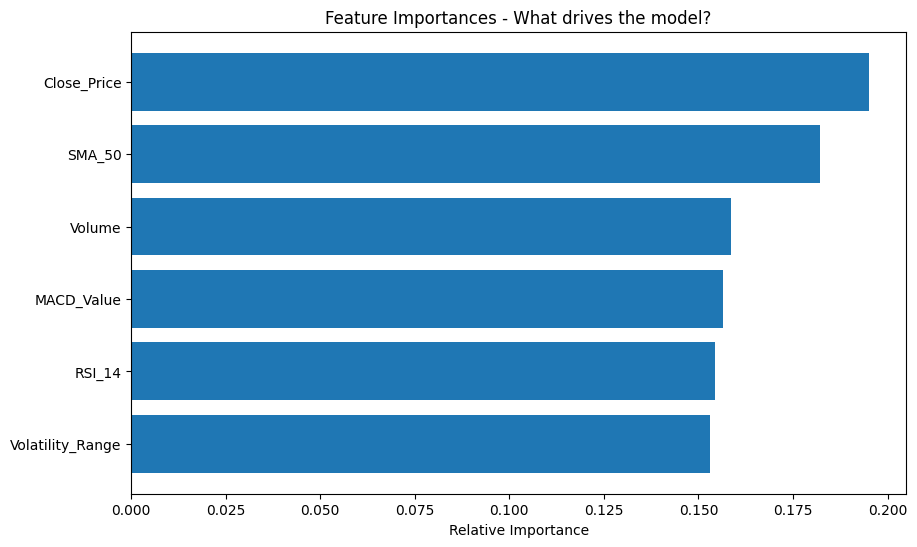

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf_model.feature_importances_ # geting feature importance from Random Forest
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances - What drives the model?')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Model Benchmarking (Logistic Regression & XGBoost)
**Description:** To ensure the best possible performance, it was compared the Random Forest results against two other popular algorithms: Logistic Regression (a linear baseline) and XGBoost (an advanced gradient boosting method).

**Insights from Results:** All models yielded very similar results (ranging from 0.40 to 0.42). The convergence of different mathematical approaches on the same accuracy level confirms that the "predictive signal" in the current features is consistent but limited by market noise. Random Forest remains the preferred model for this project due to its slightly higher initial accuracy and robustness to non-linear relationships.

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

lr_model = LogisticRegression(solver='lbfgs', max_iter = 1000) # Logistic Regression
lr_model.fit(X_train, y_train)
print(f"Logistic Regression Accuracy: {lr_model.score(X_val, y_val):.2f}")

# XGBoost (Advanced)
# XGBoost expects classes [0, 1, 2], so [-1, 0, 1] was maped to [0, 1, 2]
y_train_xgb = y_train + 1
y_val_xgb = y_val + 1
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train_xgb)
print(f"XGBoost Accuracy: {xgb_model.score(X_val, y_val_xgb):.2f}")

Logistic Regression Accuracy: 0.40
XGBoost Accuracy: 0.41


In [ ]:
final_accuracy = rf_model.score(X_test, y_test) # final test on the best model
print(f"FINAL TEST ACCURACY (The ultimate result): {final_accuracy:.2f}")

FINAL TEST ACCURACY (The ultimate result): 0.41


### Summary of Predictive Analysis

The modeling phase successfully demonstrated that technical indicators like RSI, MACD, and SMA hold predictive power, even in a high-kurtosis data environment. By shifting from a binary "Up/Down" approach to a 3-class classification (including a Neutral zone), it reduced the impact of market noise on the model's training.

**Key takeaways:**
- Reliable Edge: A consistent 8-9% edge over random chance was achieved across multiple algorithms.
- Feature Synergy: Feature importance showed that while price-action (Close/SMA) is the primary driver, momentum indicators (RSI/MACD) provide essential secondary signals that stabilize the prediction.
